<a href="https://colab.research.google.com/github/amruthaduvvuri/AB-Testing-/blob/main/A_B_testing_Old_page_vs_new_page.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Business Problem Statement** :


An e-commerce platform currently observes an average product page conversion rate of 13%. The UX team has developed a redesigned product page intended to improve the user experience and drive higher conversions. The business goal is to achieve at least a 2% absolute increase in conversion rate (from 13% to 15%), which would represent a meaningful uplift in revenue and validate the new design.

However, deploying the redesign to the entire user base without prior validation introduces risk if the new design underperforms, it may negatively impact sales and customer trust. To mitigate this risk and generate data driven insights, we need to run an A/B test on a representative subset of users.

The objective of this study is to determine whether the redesigned product page delivers a statistically significant improvement in conversion rate compared to the current design, thereby enabling the product team to make an informed rollout decision.

# ***Experiment Design for A/B Test***

1. Formulating the Hypothesis

We want to test whether the redesigned product page leads to a different conversion rate compared to the old design. Since we don’t know whether it will perform better, worse, or the same, we will use a two-tailed test.

	•	Null Hypothesis (H₀):p_{new} = p_{old}
(The new design has the same conversion rate as the old design)

	•	Alternative Hypothesis (H₁):p_{new} \neq p_{old}
(The new design has a different conversion rate than the old design)


We will test at a 95% confidence level (α = 0.05).

This means that if the probability (p-value) of observing our results under the null hypothesis is less than 5%, we reject the null in favor of the alternative.


2. **Variables**

	•	Independent Variable (Treatment):
Product page version

	•	Control group → old design

	•	Treatment group → new design

	•	Dependent Variable (Outcome):

Conversion rate (binary: 0 or 1 per session)

	•	0 → user did not purchase
	•	1 → user purchased

Conversion rate per group is simply the mean of conversions in that group.

3. Sampling & Sample Size


We cannot test on the entire user base, so we will draw samples. The sample size depends on:

	•	Effect Size (expected difference): 2% uplift (13% → 15%)
	•	Alpha (α): 0.05
	•	Power (1-β): 0.8 (80% chance of detecting a true difference)

These parameters will be used for a power analysis to calculate the required sample size for each group. Python libraries like statsmodels can automate this calculation.

4. Experimental Setup
	1.	Randomly split user sessions into Control (A) and Treatment (B) groups.
	2.	Run the experiment for a sufficient time window to collect the required sample size.
	3.	Measure conversion rates in both groups.
	4.	Apply a z-test for proportions (or chi-square test) to compare conversion rates.
	5.	Check statistical significance:

	•	If p-value < 0.05 → reject H₀ → conclude conversion rates are significantly different.

	•	If p-value ≥ 0.05 → fail to reject H₀ → conclude no significant difference.


5. Tools & Dataset

	•	Dataset: Kaggle E-Commerce or Online Shoppers Purchasing Intention Dataset (contains user sessions + conversion labels).

	•	Tech Stack: Python, Pandas, Statsmodels, Scipy, Matplotlib/Seaborn for visualization & statistical analysis.


  6. Success Criteria

The redesign will be considered successful if:
	•	Conversion rate in the treatment group is ≥ 15%.
  
	•	The observed difference is statistically significant (p < 0.05)

In [2]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

# Some plot styling preferences
plt.style.use('ggplot')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

In [3]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size,
    power=0.8,
    alpha=0.05,
    ratio=1
    )                                                  # Calculating sample size needed

required_n = ceil(required_n)                          # Rounding up to next whole number

print(required_n)

4720


Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between the designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

### ***Collecting and Preparing the data***

In [4]:
df = pd.read_csv('ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0.0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0.0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0.0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0.0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38833 entries, 0 to 38832
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       38833 non-null  int64  
 1   timestamp     38833 non-null  object 
 2   group         38833 non-null  object 
 3   landing_page  38832 non-null  object 
 4   converted     38832 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.5+ MB


In [6]:
# To make sure all the control group are seeing the old page and viceversa

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,267,19082
treatment,19207,276


There are 294478 rows in the DataFrame, each representing a user session, as well as 5 columns :


user_id - The user ID of each session

timestamp - Timestamp for the session

group - Which group the user was assigned to for that session {control, treatment}

landing_page - Which design each user saw on that session {old_page, new_page}

converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

We'll actually only use the group and converted columns for the analysis.

Before we go ahead and sample the data to get our subset, let's make sure there are no users that have been sampled multiple times.

In [7]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 76 users that appear multiple times in the dataset


In [10]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 38681 entries


# ***Sampling***

In [11]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

In [12]:
ab_test

,user_id,timestamp,group,landing_page,converted
0,931877,2017-01-11 00:28:22.096052,control,old_page,0.0
1,851347,2017-01-03 10:08:13.895233,control,old_page,0.0
2,827461,2017-01-04 19:28:27.417197,control,old_page,1.0
3,909017,2017-01-06 05:52:04.522807,control,old_page,0.0
4,809821,2017-01-12 00:13:17.249693,control,old_page,0.0
...,...,...,...,...,...
9435,842030,2017-01-22 07:11:34.217495,treatment,new_page,1.0
9436,729804,2017-01-23 11:52:45.913579,treatment,new_page,0.0
9437,928993,2017-01-16 15:18:20.987052,treatment,new_page,0.0
9438,894315,2017-01-04 16:18:55.379061,treatment,new_page,0.0


In [13]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       9440 non-null   int64  
 1   timestamp     9440 non-null   object 
 2   group         9440 non-null   object 
 3   landing_page  9440 non-null   object 
 4   converted     9440 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 368.9+ KB


In [14]:
ab_test['group'].value_counts()

,count
group,
control,4720
treatment,4720


# Visualising the **results**

In [15]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

/tmp/ipython-input-1175715124.py:6: FutureWarning: The provided callable <function mean at 0x7c5c41321c60> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])


,conversion_rate,std_deviation,std_error
group,,,
control,0.131,0.338,0.005
treatment,0.123,0.329,0.005


/tmp/ipython-input-1510267236.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)


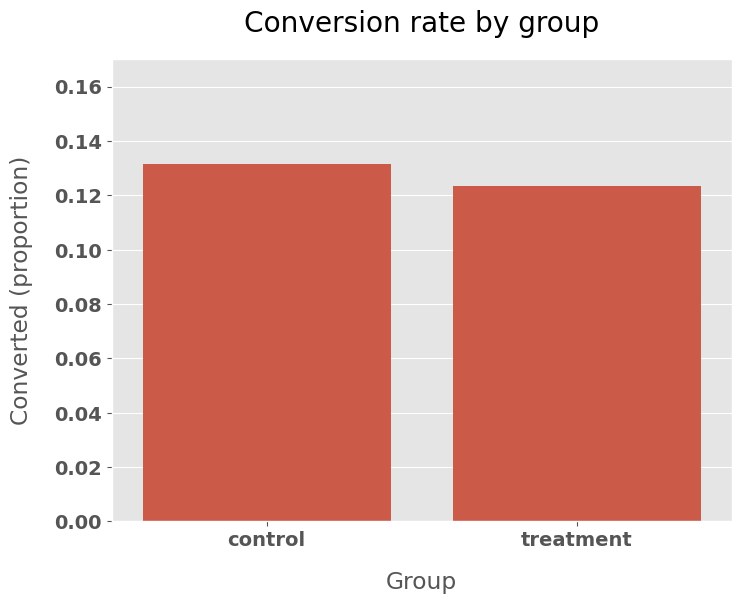

In [16]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

#  Testing the hypothesis

In [17]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [18]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [19]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: 1.17
p-value: 0.241
ci 95% for control group: [0.122, 0.141]
ci 95% for treatment group: [0.114, 0.133]


# Drawing conclusions

Since our -value=0.732 is way above our =0.05, we cannot reject the null hypothesis , which means that our new design did not perform significantly different (let alone better) than our old one

Additionally, if we look at the confidence interval for the treatment group ([0.116, 0.135], i.e. 11.6-13.5%) we notice that:

It includes our baseline value of 13% conversion rate
It does not include our target value of 15% (the 2% uplift we were aiming for)